# Training a Tetris emulator

In this notebook, we train a model to emulate Tetris and provide a backend for our model-based game engine.

In [11]:
import os
from pathlib import Path
import shutil
import datetime

import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.utils.data import Dataset
import numpy as np
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt


from models import TetrisModel, TetrisDiscriminator
import metrics
from recording import RecordingDatabase

In [12]:
class RecordingDataset(Dataset):
    def __init__(self, path: str):
        self._db = RecordingDatabase(path)

    def __len__(self):
        return len(self._db)

    def __getitem__(self, idx):
        boards = self._db[idx]
        x = self._transform(boards[-2]) # Ignore all boards except the last two
        y = self._transform(boards[-1])
        return x, y
    
    def _transform(self, board):
        board = torch.tensor(board, dtype=torch.long)
        board = F.one_hot(board, 2) # One-hot encode the cell types
        board = board.type(torch.float) # Convert to floating-point
        board = board.permute((2, 0, 1)) # Move channels/classes to dimension 0
        return board

In [13]:
train_dataset = RecordingDataset(os.path.join("data", "tetris_emulator", "train"))
test_dataset = RecordingDataset(os.path.join("data", "tetris_emulator", "test"))
batch_size = 4
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

x, y = next(iter(train_dataloader))
print(x.shape, x.dtype)
print(y.shape, y.dtype)

torch.Size([4, 2, 22, 10]) torch.float32
torch.Size([4, 2, 22, 10]) torch.float32


In [14]:
device = (
    "cuda" if torch.cuda.is_available()
    else "cpu"
)

print(f"Using {device} device")

Using cpu device


In [15]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [16]:
gen = TetrisModel().to(device)
disc = TetrisDiscriminator().to(device)

with torch.no_grad():
    X, y = next(iter(train_dataloader))
    y_gen = gen(X)
    pred_on_real = F.sigmoid(disc(X, y)[0])
    pred_on_fake = F.sigmoid(disc(X, y_gen)[0])
    print(f"Number of generator parameters: {count_parameters(gen)}")
    print(f"Number of discriminator parameters: {count_parameters(disc)}")
    print(f"Predicted label for real data: {pred_on_real}")
    print(f"Predicted label for fake data: {pred_on_fake}")

Number of generator parameters: 17996
Number of discriminator parameters: 7057
Predicted label for real data: 0.5882883071899414
Predicted label for fake data: 0.5279089212417603


In [17]:
import itertools

def find_interesting_examples(dataset, num=3):
    num_spawns = num
    
    def inner():
        num_spawns_left = num_spawns

        for x, y in dataset:
            # Check for block spawn
            if (x.argmax(0)[0] == 0).all() & (y.argmax(0)[0] == 1).any():
                if num_spawns_left > 0:
                    num_spawns_left -= 1
                    yield x, y
                else:
                    continue
            
    return list(itertools.islice(inner(), num))

In [18]:
def render_prediction(x, pred, y):
    """Renders an example and prediction into a single-image array.
    
    Inputs:
        x: Tensor of shape (height, width), the model input.
        pred: Tensor of shape (height, width), the model prediction.
        y: Tensor of shape (height, width), the target.
    """
    assert len(x.shape) == 2, f"Expected tensors of shape (width, height) but got {x.shape}"
    assert x.shape == pred.shape, f"Shapes do not match: {x.shape} != {pred.shape}"
    assert x.shape == y.shape, f"Shapes do not match: {x.shape} != {y.shape}"
    height, width = x.shape
    with torch.no_grad():
        separator = torch.ones(height, 1, dtype=x.dtype)
        return torch.cat((x, separator, pred, separator, y), dim=-1)

In [19]:
real_label = 1.0
fake_label = 0.0

def train_loop(dataloader, gen, disc, loss_fn, optimizer_gen, optimizer_disc):
    gen.train()
    disc.train()

    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        ##################################################################
        # (1) Update discriminator: minimize -log(D(x)) - log(1 - D(G(z)))
        ##################################################################
        disc.zero_grad()

        ## Train with all-real batch
        # Format batch
        X, y = X.to(device), y.to(device)
        batch_size = X.size(0)
        real_labels = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through discriminator
        output = torch.flatten(disc(X, y))
        # Calculate loss on all-real batch
        err_disc_real = loss_fn(output, real_labels)
        # Calculate gradients for discriminator in backward pass
        err_disc_real.backward()

        ## Train with all-fake batch
        # Generate fake image batch with generator
        y_fake = gen(X)
        fake_labels = torch.full((batch_size,), fake_label, dtype=torch.float, device=device)
        # Classify all fake batch with discriminator
        output = torch.flatten(disc(X, y_fake.detach()))
        # Calculate discriminator's loss on the all-fake batch
        err_disc_fake = loss_fn(output, fake_labels)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        err_disc_fake.backward()

        ## Update discriminator weights
        # Compute error of discriminator as sum over the fake and the real batches
        err_disc = err_disc_real + err_disc_fake
        # Update discriminator
        optimizer_disc.step()

        ##############################################
        # (2) Update generator: minimize -log(D(G(z)))
        ##############################################
        gen.zero_grad()
        # Since we just updated the discriminator, perform another forward pass of the all-fake batch through it
        output = torch.flatten(disc(X, y_fake))
        # Calculate the generator's loss based on this output
        # We use real labels because the generator wants to fool the discriminator
        err_gen = loss_fn(output, real_labels)
        # Calculate gradients for generator
        err_gen.backward()
        # Update generator
        optimizer_gen.step()

        # Output training stats
        if batch % 30 == 0:
            current = batch * dataloader.batch_size + batch_size
            print(f"[{current}/{size}] D loss: {err_disc.item():.4f}, G loss: {err_gen.item():.4f}")


def test_loop(split_name, dataloader, gen, disc, loss_fn, tb_writer, epoch, examples):
    gen.eval()
    disc.eval()

    loss_disc = 0.0
    loss_gen = 0.0
    disc_accuracy = 0.0
    cell_accuracy = metrics.CellAccuracy()
    board_accuracy = metrics.BoardAccuracy()
    board_plausibility = metrics.BoardPlausibility()
    spawn_recall = metrics.SpawnRecall()
    spawn_precision = metrics.SpawnPrecision()
    spawn_validity = metrics.SpawnValidity()
    scores_real = np.zeros(len(dataloader.dataset))
    scores_fake = np.zeros(len(dataloader.dataset))
    spawn_diversity = metrics.SpawnDiversity()

    num_batches = len(dataloader)
    with torch.no_grad():        
        for batch, (X, y) in enumerate(dataloader):
            batch_size = X.size(0)
            real_labels = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
            fake_labels = torch.full((batch_size,), fake_label, dtype=torch.float, device=device)

            output_real = disc(X, y)
            loss_disc += loss_fn(output_real, real_labels).item()

            y_fake = gen(X)
            output_fake = disc(X, y_fake)
            
            loss_disc += loss_fn(output_fake, fake_labels).item()
            loss_gen += loss_fn(output_fake, real_labels).item()

            pred_real = (output_real > 0.0)
            pred_fake = (output_fake > 0.0)
            disc_accuracy += pred_real.type(torch.float).mean().item()
            disc_accuracy += (~pred_fake).type(torch.float).mean().item()

            classes_X = torch.argmax(X, dim=1)
            classes_y = torch.argmax(y, dim=1)
            classes_y_fake = torch.argmax(y_fake, dim=1)
            cell_accuracy.update_state(classes_y_fake, classes_y)
            board_accuracy.update_state(classes_y_fake, classes_y)
            board_plausibility.update_state(classes_X, classes_y_fake, classes_y)

            spawn_recall.update_state(classes_X, classes_y_fake, classes_y)
            spawn_precision.update_state(classes_X, classes_y_fake, classes_y)
            spawn_validity.update_state(classes_X, classes_y_fake)

            start_index = dataloader.batch_size * batch
            end_index = start_index + batch_size
            scores_real[start_index:end_index] = torch.sigmoid(output_real).numpy()
            scores_fake[start_index:end_index] = torch.sigmoid(output_fake).numpy()

            spawn_diversity.update_state(classes_X, classes_y_fake)

    loss_disc /= num_batches
    loss_gen /= num_batches
    disc_accuracy /= (2.0 * num_batches)

    print(f"{split_name} error: \n D loss: {loss_disc:>8f}, G loss: {loss_gen:>8f}, D accuracy: {(100*disc_accuracy):>0.1f}%, cell accuracy: {(cell_accuracy.result()):>0.1%}, board accuracy: {(board_accuracy.result()):>0.1%} \n")

    tb_writer.add_scalar(f"Discriminator loss/{split_name}", loss_disc, epoch)
    tb_writer.add_scalar(f"Loss/{split_name}", loss_gen, epoch)
    tb_writer.add_scalar(f"Discriminator accuracy/{split_name}", disc_accuracy, epoch)
    tb_writer.add_scalar(f"Cell accuracy/{split_name}", cell_accuracy.result(), epoch)
    tb_writer.add_scalar(f"Board accuracy/{split_name}", board_accuracy.result(), epoch)
    tb_writer.add_scalar(f"Board plausibility/{split_name}", board_plausibility.result(), epoch)
    tb_writer.add_scalar(f"Spawn recall/{split_name}", spawn_recall.result(), epoch)
    tb_writer.add_scalar(f"Spawn precision/{split_name}", spawn_precision.result(), epoch)
    tb_writer.add_scalar(f"Spawn validity/{split_name}", spawn_validity.result(), epoch)
    tb_writer.add_scalar(f"Spawn diversity/{split_name}", spawn_diversity.result(), epoch)

    with torch.no_grad():
        for i, (X, y) in enumerate(examples):
            X, y = X.unsqueeze(0), y.unsqueeze(0)
            y_fake = gen(X)
            X, y, y_fake = X.squeeze(0), y.squeeze(0), y_fake.squeeze(0)
            X, y, y_fake = X.argmax(0), y.argmax(0), y_fake.argmax(0)
            img = render_prediction(X, y_fake, y)
            tb_writer.add_image(f"Predictions/{split_name}/{i}", img, epoch, dataformats="HW")
    
    tb_writer.add_histogram(f"Discriminator scores/{split_name}/real", scores_real, epoch)
    tb_writer.add_histogram(f"Discriminator scores/{split_name}/fake", scores_fake, epoch)


In [20]:
learning_rate = 1e-4
epochs = 300

gen = TetrisModel().to(device)
disc = TetrisDiscriminator().to(device)

loss_fn = nn.BCEWithLogitsLoss()
optimizer_gen = torch.optim.Adam(gen.parameters(), lr=learning_rate)
optimizer_disc = torch.optim.Adam(disc.parameters(), lr=learning_rate)

log_dir = os.path.join("runs", "tetris_emulator")
log_subdir = os.path.join(log_dir, datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
tb_writer = SummaryWriter(log_subdir)

train_examples = find_interesting_examples(train_dataset)
test_examples = find_interesting_examples(test_dataset)

for epoch in range(epochs):
    print(f"Epoch {epoch}\n-------------------------------")
    train_loop(train_dataloader, gen, disc, loss_fn, optimizer_gen, optimizer_disc)
    test_loop("train", train_dataloader, gen, disc, loss_fn, tb_writer, epoch, train_examples)
    test_loop("test", test_dataloader, gen, disc, loss_fn, tb_writer, epoch, test_examples)
    gen_zero_grads = 0
    for name, weight in gen.named_parameters():
        tb_writer.add_histogram(f"Weights/{name}", weight, epoch)
        if weight.grad is not None:
            tb_writer.add_histogram(f"Gradients/{name}", weight.grad, epoch)
            gen_zero_grads += weight.grad.numel() - weight.grad.count_nonzero().item()
    tb_writer.add_scalar(f"Zero gradients", gen_zero_grads, epoch)
    disc_zero_grads = 0
    for name, weight in disc.named_parameters():
        tb_writer.add_histogram(f"Discriminator weights/{name}", weight, epoch)
        if weight.grad is not None:
            tb_writer.add_histogram(f"Discriminator gradients/{name}", weight.grad, epoch)
            disc_zero_grads += weight.grad.numel() - weight.grad.count_nonzero().item()
    tb_writer.add_scalar(f"Discriminator zero gradients", disc_zero_grads, epoch)

tb_writer.close()
print("Done!")

Epoch 0
-------------------------------
[4/1778] D loss: 1.3876, G loss: 0.6675
[124/1778] D loss: 1.3504, G loss: 0.6491
[244/1778] D loss: 1.3430, G loss: 0.6344
[364/1778] D loss: 1.3217, G loss: 0.6277
[484/1778] D loss: 1.2160, G loss: 0.7047
[604/1778] D loss: 1.1163, G loss: 0.7825
[724/1778] D loss: 1.0084, G loss: 0.8382
[844/1778] D loss: 0.8709, G loss: 1.0203
[964/1778] D loss: 0.7319, G loss: 1.1359
[1084/1778] D loss: 0.5979, G loss: 1.2188
[1204/1778] D loss: 0.4833, G loss: 1.5985
[1324/1778] D loss: 0.3306, G loss: 1.9530
[1444/1778] D loss: 0.2820, G loss: 2.3131
[1564/1778] D loss: 0.2216, G loss: 2.4783
[1684/1778] D loss: 0.2664, G loss: 2.4259
train error: 
 D loss: 0.313720, G loss: 2.593960, D accuracy: 96.0%, cell accuracy: 18581.6%%, board accuracy: 0.0% 

test error: 
 D loss: 0.309808, G loss: 2.616915, D accuracy: 95.8%, cell accuracy: 18524.1%%, board accuracy: 0.0% 

Epoch 1
-------------------------------
[4/1778] D loss: 0.1862, G loss: 3.0172


c:\Projects\tetris-emulator\metrics.py:199: RuntimeWarning: invalid value encountered in divide
  probs = self.predicted_spawn_type_counts / num_predicted_spawns


[124/1778] D loss: 0.2015, G loss: 3.0198
[244/1778] D loss: 0.1306, G loss: 3.0649
[364/1778] D loss: 0.1401, G loss: 3.4345
[484/1778] D loss: 0.1446, G loss: 3.6977
[604/1778] D loss: 0.0780, G loss: 3.9261
[724/1778] D loss: 0.0968, G loss: 3.6195
[844/1778] D loss: 0.1617, G loss: 3.5085
[964/1778] D loss: 0.1257, G loss: 4.1769
[1084/1778] D loss: 0.1291, G loss: 3.5585
[1204/1778] D loss: 0.1143, G loss: 3.6501
[1324/1778] D loss: 0.2275, G loss: 4.1440
[1444/1778] D loss: 0.3022, G loss: 4.2715
[1564/1778] D loss: 0.0852, G loss: 3.8730
[1684/1778] D loss: 0.3967, G loss: 2.7460
train error: 
 D loss: 0.222812, G loss: 4.112778, D accuracy: 99.0%, cell accuracy: 21138.2%%, board accuracy: 0.0% 

test error: 
 D loss: 0.227431, G loss: 4.062106, D accuracy: 99.3%, cell accuracy: 21123.9%%, board accuracy: 0.0% 

Epoch 2
-------------------------------
[4/1778] D loss: 0.1777, G loss: 3.6535
[124/1778] D loss: 0.1586, G loss: 3.6505
[244/1778] D loss: 0.1812, G loss: 3.6917
[364/

c:\Projects\tetris-emulator\metrics.py:226: RuntimeWarning: invalid value encountered in scalar divide
  return self.num_true_positives / self.num_spawns_pred
c:\Projects\tetris-emulator\metrics.py:277: RuntimeWarning: invalid value encountered in scalar divide
  return self.num_valid_spawns_pred / self.num_spawns_pred


[124/1778] D loss: 1.0537, G loss: 1.9737
[244/1778] D loss: 0.9726, G loss: 1.6956
[364/1778] D loss: 0.8364, G loss: 0.9437
[484/1778] D loss: 0.4975, G loss: 2.0551
[604/1778] D loss: 0.8167, G loss: 1.5756
[724/1778] D loss: 0.6838, G loss: 1.6669
[844/1778] D loss: 0.4317, G loss: 2.8702
[964/1778] D loss: 0.7180, G loss: 1.6015
[1084/1778] D loss: 0.6843, G loss: 1.2982
[1204/1778] D loss: 0.7450, G loss: 1.5983
[1324/1778] D loss: 0.6481, G loss: 2.0884
[1444/1778] D loss: 0.8900, G loss: 1.3227
[1564/1778] D loss: 0.9190, G loss: 0.8142
[1684/1778] D loss: 0.9667, G loss: 0.9274
train error: 
 D loss: 0.858238, G loss: 1.503825, D accuracy: 81.8%, cell accuracy: 21567.1%%, board accuracy: 9.4% 

test error: 
 D loss: 0.875702, G loss: 1.489287, D accuracy: 81.2%, cell accuracy: 21542.1%%, board accuracy: 8.1% 

Epoch 5
-------------------------------
[4/1778] D loss: 1.0083, G loss: 1.2165
[124/1778] D loss: 0.7448, G loss: 0.8386
[244/1778] D loss: 0.9138, G loss: 1.5865
[364/

In [33]:
# Run this as many times as needed to "top-up" the training

extra_epochs = 10

tb_writer = SummaryWriter(log_subdir)

for epoch in range(epochs, epochs + extra_epochs):
    print(f"Epoch {epoch}\n-------------------------------")
    train_loop(train_dataloader, gen, disc, loss_fn, optimizer_gen, optimizer_disc)
    test_loop("train", train_dataloader, gen, disc, loss_fn, tb_writer, epoch, train_examples)
    test_loop("test", test_dataloader, gen, disc, loss_fn, tb_writer, epoch, test_examples)
    gen_zero_grads = 0
    for name, weight in gen.named_parameters():
        tb_writer.add_histogram(f"Weights/{name}", weight, epoch)
        if weight.grad is not None:
            tb_writer.add_histogram(f"Gradients/{name}", weight.grad, epoch)
            gen_zero_grads += weight.grad.numel() - weight.grad.count_nonzero().item()
    tb_writer.add_scalar(f"Zero gradients", gen_zero_grads, epoch)
    disc_zero_grads = 0
    for name, weight in disc.named_parameters():
        tb_writer.add_histogram(f"Discriminator weights/{name}", weight, epoch)
        if weight.grad is not None:
            tb_writer.add_histogram(f"Discriminator gradients/{name}", weight.grad, epoch)
            disc_zero_grads += weight.grad.numel() - weight.grad.count_nonzero().item()
    tb_writer.add_scalar(f"Discriminator zero gradients", disc_zero_grads, epoch)

tb_writer.close()

epochs += extra_epochs

print("Done!")

Epoch 305
-------------------------------
[4/1778] D loss: 1.2935, G loss: 1.5377
[124/1778] D loss: 1.3951, G loss: 0.7786
[244/1778] D loss: 1.0764, G loss: 1.0401
[364/1778] D loss: 1.1325, G loss: 0.8081
[484/1778] D loss: 1.0554, G loss: 1.3675
[604/1778] D loss: 1.3883, G loss: 0.7006
[724/1778] D loss: 1.0814, G loss: 1.1674
[844/1778] D loss: 1.1213, G loss: 1.5481
[964/1778] D loss: 1.1007, G loss: 1.0564
[1084/1778] D loss: 1.3871, G loss: 0.7127
[1204/1778] D loss: 1.3914, G loss: 0.7048
[1324/1778] D loss: 1.3956, G loss: 0.7548
[1444/1778] D loss: 1.3821, G loss: 0.6860
[1564/1778] D loss: 1.3896, G loss: 0.7105
[1684/1778] D loss: 1.3888, G loss: 0.6877
train error: 
 D loss: 1.299540, G loss: 0.901601, D accuracy: 53.5%, cell accuracy: 21961.2%%, board accuracy: 88.0% 

test error: 
 D loss: 1.290595, G loss: 0.975329, D accuracy: 54.5%, cell accuracy: 21951.4%%, board accuracy: 86.3% 

Epoch 306
-------------------------------
[4/1778] D loss: 1.3890, G loss: 0.7333
[12

In [34]:
def show_prediction(example):
    x, y = example
    pred = gen(x.unsqueeze(0)).squeeze(0)
    x, y, pred = x.argmax(0), y.argmax(0), pred.argmax(0)

    fig, axs = plt.subplots(1, 3)
    fig.suptitle("Prediction vs reality")

    for ax in axs:
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

    axs[0].set_title("Input")
    axs[1].set_title("Predicted")
    axs[2].set_title("Reality")

    axs[0].imshow(x, vmin=0, vmax=1)
    axs[1].imshow(pred, vmin=0, vmax=1)
    axs[2].imshow(y, vmin=0, vmax=1)

    plt.show()

Showing prediction for training example 1559


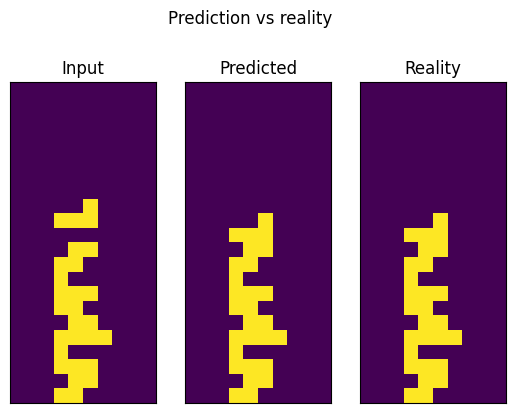

In [35]:
# Show a random training prediction vs reality
import random

idx = random.randrange(len(train_dataset))
print(f"Showing prediction for training example {idx}")
show_prediction(train_dataset[idx])

Showing prediction for test example 117


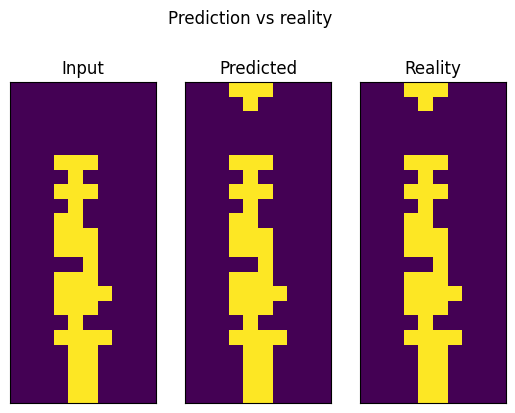

In [36]:
# Show a random test prediction vs reality
idx = random.randrange(len(test_dataset))
print(f"Showing prediction for test example {idx}")
show_prediction(test_dataset[idx])

In [37]:
def get_mistake_counts(gen, dataloader):
    mistake_counts = np.zeros(len(dataloader.dataset), dtype=np.int32)

    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            batch_size = X.size(0)

            X, y = X.to(device), y.to(device)
            y_fake = gen(X)

            classes_y = torch.argmax(y, dim=1)
            classes_y_fake = torch.argmax(y_fake, dim=1)
            num_mistakes = (classes_y_fake != classes_y).type(torch.int).sum(dim=[1, 2]).numpy()
            batch_start = batch * dataloader.batch_size
            batch_end = batch_start + batch_size
            mistake_counts[batch_start:batch_end] = num_mistakes
    
    return mistake_counts

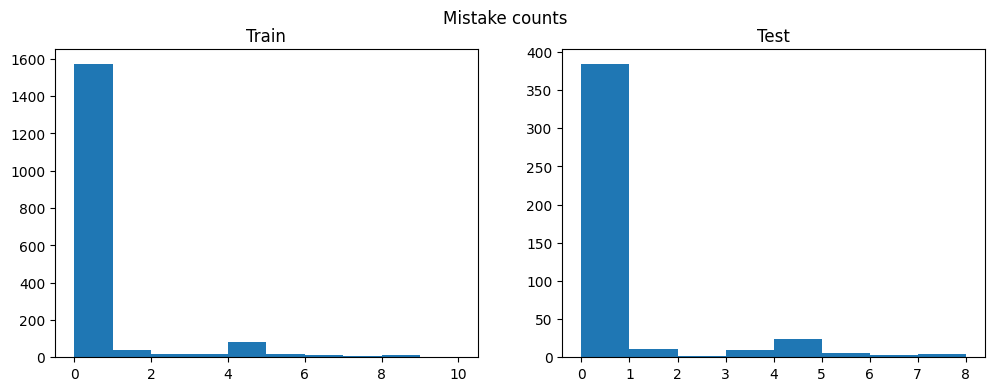

In [38]:
mistake_counts_train = get_mistake_counts(gen, train_dataloader)
mistake_counts_test = get_mistake_counts(gen, test_dataloader)
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle("Mistake counts")
axs[0].set_title("Train")
axs[0].hist(mistake_counts_train, bins=list(range(mistake_counts_train.max())))
axs[1].set_title("Test")
axs[1].hist(mistake_counts_test, bins=list(range(mistake_counts_test.max())))
plt.show()

In [39]:
def get_mistake_heatmap(gen, dataloader):
    heatmap = np.zeros((22, 10))

    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            batch_size = X.size(0)

            X, y = X.to(device), y.to(device)
            y_fake = gen(X)

            classes_y = torch.argmax(y, dim=1)
            classes_y_fake = torch.argmax(y_fake, dim=1)
            mistakes = (classes_y_fake != classes_y).type(torch.float).sum(dim=0).numpy()
            heatmap += mistakes
    
    return heatmap

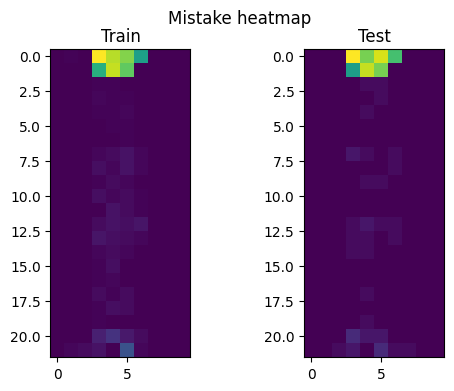

In [40]:
heatmap_train = get_mistake_heatmap(gen, train_dataloader)
heatmap_test = get_mistake_heatmap(gen, test_dataloader)
fig, axs = plt.subplots(1, 2, figsize=(6, 4))
fig.suptitle("Mistake heatmap")
axs[0].set_title("Train")
axs[0].imshow(heatmap_train)
axs[1].set_title("Test")
axs[1].imshow(heatmap_test)
plt.show()

In [41]:
print(heatmap_train)
print(heatmap_train.sum())

[[  0.   1.   0. 103.  92.  84.  58.   0.   0.   0.]
 [  0.   0.   0.  65.  94.  78.   0.   0.   0.   0.]
 [  0.   0.   0.   1.   1.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   2.   1.   1.   0.   0.   0.   0.]
 [  0.   0.   0.   1.   1.   2.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   1.   1.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   1.   0.   0.   0.   0.]
 [  0.   0.   0.   2.   3.   5.   2.   0.   0.   0.]
 [  0.   0.   0.   4.   2.   5.   2.   0.   0.   0.]
 [  0.   0.   0.   1.   3.   2.   0.   0.   0.   0.]
 [  0.   0.   0.   4.   2.   3.   1.   0.   0.   0.]
 [  0.   0.   0.   0.   5.   3.   1.   0.   0.   0.]
 [  0.   0.   0.   3.   5.   4.   6.   0.   0.   0.]
 [  0.   0.   0.   6.   4.   3.   2.   0.   0.   0.]
 [  0.   0.   0.   2.   3.   2.   0.   0.   0.   0.]
 [  0.   0.   0.   1.   4.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   1.   2.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   3.   1.   3.   0.   0.   0.   0.]
 [  0.   0.   0.   1.   4.   3.   0.   0.   0.

In [42]:
def find_failed_example_by_cell(dataloader, cell):
    i, j = cell

    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            batch_size = X.size(0)

            X, y = X.to(device), y.to(device)
            y_fake = gen(X)

            classes_X = torch.argmax(X, dim=1)
            classes_y = torch.argmax(y, dim=1)
            classes_y_fake = torch.argmax(y_fake, dim=1)
            mistakes = (classes_y_fake != classes_y)
            failed_in_cell = mistakes[:, i, j]
            for batch_idx, failed in enumerate(failed_in_cell):
                if failed:
                    dataset_idx = batch * dataloader.batch_size + batch_idx
                    return dataset_idx, (classes_X[batch_idx], classes_y_fake[batch_idx], classes_y[batch_idx])

Showing failed prediction for example 3


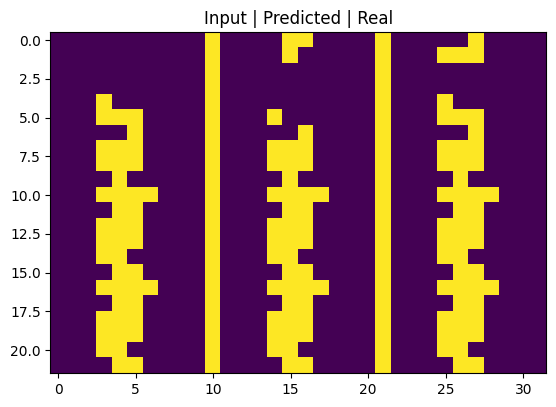

In [43]:
cell = (1, 5)

idx, (x, y_fake, y) = find_failed_example_by_cell(train_dataloader, cell)
print(f"Showing failed prediction for example {idx}")
fig, ax = plt.subplots(1, 1)
ax.set_title("Input | Predicted | Real")
ax.imshow(render_prediction(x, y_fake, y))

In [44]:
torch.save(gen.state_dict(), "tetris_emulator.pth")
torch.save(disc.state_dict(), "tetris_discriminator.pth")